In [1]:
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

import dataprovider_pypots as dp
import process_edited as pce
import VAE as vae
import DIFF as diff_mod   # DIFF 모듈
import Evaluation.Metrics as mt
import Evaluation.predictive_metrics as pdm

from dataprovider_pypots import (
    add_continuous_metadata_noise_subset,
    flip_categorical_metadata_subset,
)

device = "cuda"

# ------------------------
# 1. 데이터셋 설정
# ------------------------
# time_col은 실제 데이터셋 column 이름에 맞게 확인해서 수정해줘야 함!
dataset_configs = {
    #"Metro_Traffic": {
    #     "path": "dataset/Metro_Traffic.csv",
    #     "reader": pd.read_csv,
    #     "target_columns": ["weather_main", "temp"],
    #     "time_col": "date",       # 실제 time 컬럼명 확인 필요
    #},
    #"Pollution Data": {
    #     "path": "dataset/Pollution Data.csv",
    #     "reader": pd.read_csv,
    #     "target_columns": ["cbwd", "Iws"],
    #     "time_col": "date",
    #},
    #"Hurricane": {
    #    "path": "dataset/Hurricane.csv",
    #    "reader": pd.read_csv,
    #    "target_columns": ["year", "trend"],
    #    "time_col": "date",  # 실제 time 컬럼명에 맞게 수정
    #},
    #"AirQuality": {
    #     "path": "dataset/AirQuality.csv",
    #     "reader": pd.read_csv,
    #     "target_columns": ["NOx(GT)", "NO2(GT)"],
    #     "time_col": "date",       # 예시: 실제 컬럼명 확인 필요
    #},
    "ETTh1": {
         "path": "dataset/ETTh1.csv",
         "reader": pd.read_csv,
         "target_columns": ["LULL", "OT"],
         "time_col": "date",       # 실제 컬럼명에 맞게 수정
    },
    #"Energy": {
    #     "path": "dataset/energy_data.csv",
    #     "reader": pd.read_csv,
    #     "target_columns": ["lights", "rv1"],
    #     "time_col": "date",       # 실제 컬럼명에 맞게 수정
    #},
}

# ------------------------
# 2. 공통 하이퍼파라미터
# ------------------------
VAE_training = 10000
diff_training = 50000
lat_dim = 6

vae_n_epochs = VAE_training
eps = 1e-5
weight_decay = 1e-6
lr = 2e-4
hidden_size = 512
num_layers_vae = 2
batch_size = 100
channels = 64
min_beta = 1e-5
max_beta = 0.1
emb_dim = 128
time_dim = 8
threshold = 1

diff_n_epochs = diff_training
hidden_dim = 200
num_layers_diff = 2
diffusion_steps = 100

# robustness 실험 설정
levels = [0.0, 0.1, 0.2, 0.4, 0.6]
iterations = 1000
num_runs = 5

seq_len = 96
stride = 1
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# ------------------------
# 3. 결과 저장용 딕셔너리
# ------------------------
disc_results = {}  # {dataset_name: {"mean": [...], "std": [...]} }
temp_results = {}

# ------------------------
# 4. 데이터셋 루프
# ------------------------
for ds_name, cfg in dataset_configs.items():
    print("\n\n==============================")
    print(f"=== Dataset: {ds_name} ===")
    print("==============================")

    # 4-1) 데이터 로딩
    reader = cfg["reader"]
    path = cfg["path"]
    target_columns = cfg["target_columns"]
    time_col = cfg["time_col"]

    real_df = reader(path)

    # --- 데이터셋별 간단 전처리 (필요시 조건문 추가) ---
    if ds_name == "bike_sharing":
        cols = real_df.columns.to_list()
        cols[1] = "date"
        real_df.columns = cols
        real_df = real_df.drop(columns=["instant", "yr", "mnth"])

    if ds_name == "Metro_Traffic":
        if "holiday" in real_df.columns:
            real_df["holiday"] = real_df["holiday"].fillna(0)

    if ds_name == "Pollution Data":
        if "pm2.5" in real_df.columns:
            real_df["pm2.5"] = real_df["pm2.5"].fillna(0)

    # time_col이 실제로 존재하는지 체크 (없으면 에러)
    assert (
        time_col in real_df.columns
    ), f"{ds_name}: time_col '{time_col}' not found in columns!"

    # 4-2) TVMCG용 데이터 준비
    real_df1 = real_df.drop([time_col], axis=1)
    parser_tmp = pce.DataFrameParser().fit(real_df1, 1)
    column_name = parser_tmp.column_name()

    pdset = dp.TVMCG(
        real_df.iloc[0:2000,:],  # 필요시 길이 조정
        train_ratio=train_ratio,
        val_ratio=val_ratio,
        test_ratio=test_ratio,
        seq_len=seq_len,
        stride=stride,
        column_list=column_name,
        target_column=target_columns,
    )

    # 4-3) VAE 학습
    ds = vae.train_autoencoder_best_train(
        None,
        channels,
        hidden_size,
        num_layers_vae,
        lr,
        weight_decay,
        vae_n_epochs,
        batch_size,
        threshold,
        min_beta,
        max_beta,
        emb_dim,
        time_dim,
        lat_dim,
        device,
        pdset,
    )
    latent_features = ds[1]




=== Dataset: ETTh1 ===


Output()

In [ ]:
# 4-4) Diffusion 학습
num_classes = len(latent_features)
diff_model = diff_mod.train_diffusion(
    latent_features,
    None,
    pdset,
    hidden_dim,
    num_layers_diff,
    diffusion_steps,
    diff_n_epochs,
    num_classes,
)

In [2]:
# 4-5) Robustness 실험 준비
Batch_size, Seq_len, _ = pdset["response_train"].shape
Lat_dim = lat_dim

base_target_mask = pdset["target_mask_train"]
base_target = pdset["response_train"]
base_cond = pdset["cond_train"]
base_time_info = pdset["time_info_train"]

target_idx = pdset["target_idx"]
cont_meta_idx = pdset["cond_cont_idx"]
cat_meta_idx = pdset["cond_cat_idx"]
cat_num_classes = pdset["cat_num_classes_idx"]

disc_mean = []
disc_std = []
tmp_mean = []
tmp_std = []

# (4) Decode
parser = pdset["parser"]  # TVMCG에서 저장한 parser
gen_output = ds[0].decoder(latent_features.to(device), base_target_mask, base_cond)
_synth_data = pce.convert_to_tensor(parser, gen_output, 1, Batch_size, Seq_len)

# (5) target feature만 사용
target_test1 = base_target[:, :, target_idx].detach().cpu()
_synth_data1 = _synth_data[:, :, target_idx].detach().cpu()


/tmp/ipykernel_187101/1131138074.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend(loc='upper left')


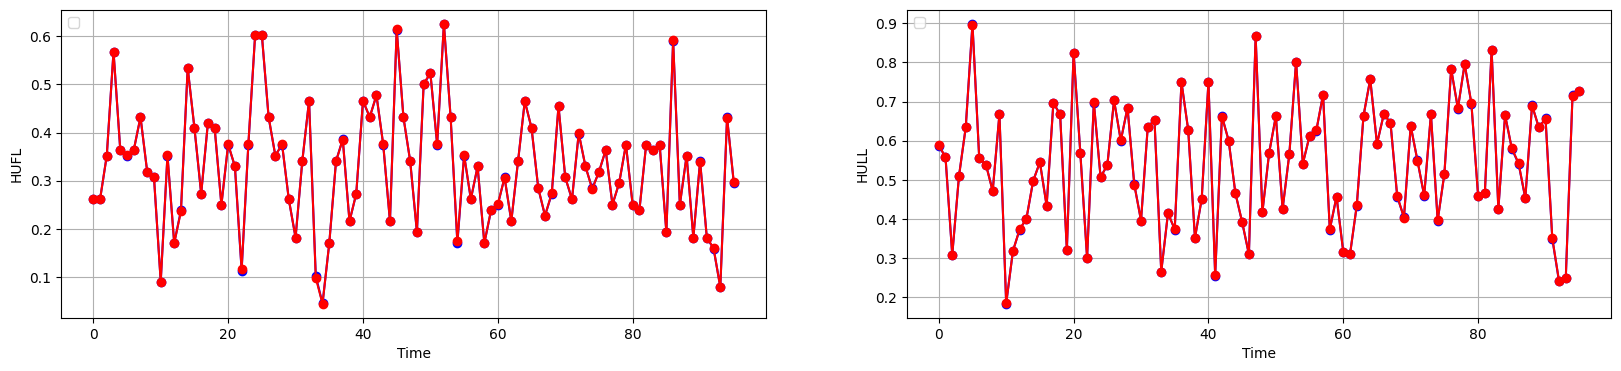

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4)) 
label = 100
# Plot histogram for the specified column
for i in range(0,2):
    axes[i].plot(target_test1[label,:,i],  marker='o', linestyle='-', color='b')
    axes[i].plot(_synth_data1[label,:,i].cpu(),  marker='o', linestyle='-', color='r')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(f'{column_name[i]}')
    axes[i].grid(True)
    axes[i].legend(loc='upper left')

plt.show()

In [ ]:
# (6) Metrics
disc_score = mt.discriminative_score_metrics(
    target_test, _synth_data, iterations
)
tmp_score = mt.temp_disc_score(
    target_test, _synth_data, iterations
)

✅ Saved: figures/discriminative_score_vs_alpha.png


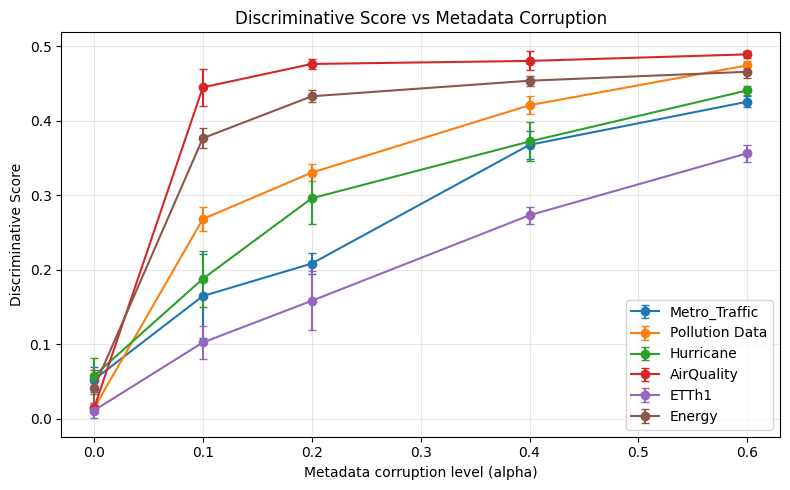

✅ Saved: figures/temporal_score_vs_alpha.png


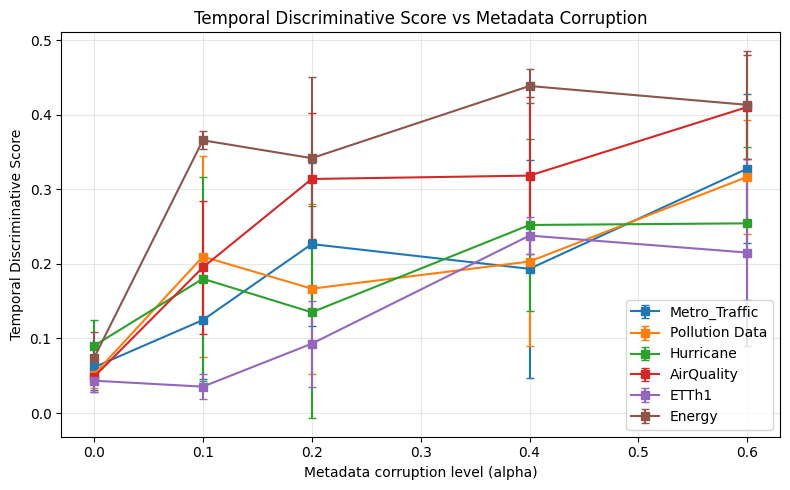

In [5]:
import os
import matplotlib.pyplot as plt

# 공통 x축 (alpha == level)
levels = [0.0, 0.1, 0.2, 0.4, 0.6]

# ---- 데이터 정의 ----
data = {
    "Metro_Traffic": {
        "disc_mean": [0.0522, 0.1646, 0.2082, 0.3677, 0.4256],
        "disc_std":  [0.0167, 0.0562, 0.0137, 0.0188, 0.0075],
        "temp_mean": [0.0614, 0.1247, 0.2266, 0.1934, 0.3278],
        "temp_std":  [0.0304, 0.0796, 0.1092, 0.1461, 0.0994],
    },
    "Pollution Data": {
        "disc_mean": [0.0136, 0.2680, 0.3304, 0.4209, 0.4744],
        "disc_std":  [0.0048, 0.0161, 0.0119, 0.0121, 0.0060],
        "temp_mean": [0.0516, 0.2098, 0.1668, 0.2032, 0.3168],
        "temp_std":  [0.0178, 0.1352, 0.1139, 0.1127, 0.0764],
    },
    "Hurricane": {
        "disc_mean": [0.0573, 0.1877, 0.2959, 0.3722, 0.4408],
        "disc_std":  [0.0242, 0.0377, 0.0347, 0.0257, 0.0056],
        "temp_mean": [0.0902, 0.1801, 0.1351, 0.2522, 0.2544],
        "temp_std":  [0.0349, 0.1371, 0.1422, 0.1153, 0.1028],
    },
    "AirQuality": {
        "disc_mean": [0.0136, 0.4449, 0.4763, 0.4804, 0.4892],
        "disc_std":  [0.0067, 0.0248, 0.0069, 0.0128, 0.0049],
        "temp_mean": [0.0484, 0.1953, 0.3139, 0.3184, 0.4104],
        "temp_std":  [0.0200, 0.0891, 0.0891, 0.1053, 0.0691],
    },
    # === UPDATED ETTh1 ===
    "ETTh1": {
        "disc_mean": [0.0108, 0.1022, 0.1582, 0.2731, 0.3563],
        "disc_std":  [0.0105, 0.0216, 0.0395, 0.0113, 0.0113],
        "temp_mean": [0.0434, 0.0354, 0.0930, 0.2380, 0.2152],
        "temp_std":  [0.0155, 0.0168, 0.0579, 0.0251, 0.1254],
    },
    "Energy": {
        "disc_mean": [0.0411, 0.3766, 0.4329, 0.4538, 0.4658],
        "disc_std":  [0.0238, 0.0137, 0.0079, 0.0065, 0.0085],
        "temp_mean": [0.0737, 0.3658, 0.3418, 0.4386, 0.4133],
        "temp_std":  [0.0347, 0.0122, 0.1088, 0.0231, 0.0726],
    },
}

# ---- 폴더 생성 ----
os.makedirs("figures", exist_ok=True)

# ========= Plot 1: Discriminative Score =========
plt.figure(figsize=(8, 5))
for name, v in data.items():
    plt.errorbar(
        levels, v["disc_mean"], yerr=v["disc_std"],
        marker="o", capsize=3, label=name
    )
plt.xlabel("Metadata corruption level (alpha)")
plt.ylabel("Discriminative Score")
plt.title("Discriminative Score vs Metadata Corruption")
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()

# 🔹 저장
disc_path = "figures/discriminative_score_vs_alpha.png"
plt.savefig(disc_path, dpi=300, bbox_inches="tight")
print(f"✅ Saved: {disc_path}")
plt.show()

# ========= Plot 2: Temporal Score =========
plt.figure(figsize=(8, 5))
for name, v in data.items():
    plt.errorbar(
        levels, v["temp_mean"], yerr=v["temp_std"],
        marker="s", capsize=3, label=name
    )
plt.xlabel("Metadata corruption level (alpha)")
plt.ylabel("Temporal Discriminative Score")
plt.title("Temporal Discriminative Score vs Metadata Corruption")
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()

# 🔹 저장
temp_path = "figures/temporal_score_vs_alpha.png"
plt.savefig(temp_path, dpi=300, bbox_inches="tight")
print(f"✅ Saved: {temp_path}")
plt.show()
